### Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import umap

from pathlib import Path
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

### Device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Constants

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = 12
EMBEDDING_SIZE = 384
NUM_LAYERS = 3
NUM_EPOCHS = 10
DATA_DIR = Path('../data/dataset/')
LOOKBACK = 10
LOWEST_FREQUENCY = 50
KERNEL_SIZE = 3
SUBSET = ['imu', 'odom', 'cmd_vel', 'servo']

### Load and split data

In [4]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)

In [5]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1']

In [6]:
X = pd.Series([run[0] for run in dataset], name='bag_name')
y_primary = [run[1] for run in dataset]

In [8]:
# y_secondary = ['slippery' if label in ('1_Panele', '5_Spienione_PCV', '6_Linoleum')
#                else 'grippy' if label in ('3_Wykladzina_jasna', '8_Pusta_plyta', '9_podklady')
#                else 'neutral' for label in y_primary]
y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
               else 'grippy' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
               else 'neutral' for label in y_primary] # Pawel set
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('2_Wykladzina_czarna', '5_Spienione_PCV', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Clustering set

In [9]:
le = LabelEncoder()
le.fit(y_secondary)
classes = le.classes_
num_classes = len(classes)
y = le.transform(y_secondary)
y = y.reshape(-1, 1)

In [10]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, stratify=y_training)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### Custom datasets

In [11]:
def select_sequence(series, selected_columns, window_length, stride):
    series = series[selected_columns]
    initial_timestep = random.randint(0, (len(series) - 1) - window_length)
    final_timestep = initial_timestep + window_length
    timesteps = list(range(initial_timestep, final_timestep + stride, stride))
    return series.iloc[timesteps].to_numpy()

In [12]:
class SurfaceDataset(Dataset):
    def __init__(self, samples, labels, frequency=50, lookback=1, subset=None):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
            frequency: The lowest frequency of collected data
            lookback: Size of window for prediction
        """

        self.samples = samples
        self.labels = labels
        self.frequency = frequency
        self.lookback = int(lookback * self.frequency)
        self.stride = int(300 / self.frequency)
        self.window_length = self.lookback * self.stride
        if subset:
            self.subset = set(subset)
        else:
            self.subset = ('cmd_vel', 'imu', 'odom', 'servo')
        measurements = {
            'cmd_vel': ['linear.x', 'angular.z'],
            'imu': ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z'],
            'odom': ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z'],
            'servo': ['values'],
        }
        self.selected_columns = []
        for measurement in self.subset:
            self.selected_columns.extend(measurements[measurement])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single, windowed time series from dataset
        """

        sample = self.samples[idx]
        run = pd.read_csv(sample, index_col=[0]).drop('Time', axis=1)
        
        X = select_sequence(run, self.selected_columns, self.window_length, self.stride)
        X['values'] /= 1000
        y = self.labels[idx]
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

train_dataloader = DataLoader(SurfaceDataset(X_train, y_train, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(SurfaceDataset(X_val, y_val, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(SurfaceDataset(X_test, y_test, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=1)

In [13]:
class TripletDataset(Dataset):
    def __init__(self, samples, labels, frequency=50, lookback=1, subset=None):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
            frequency: The lowest frequency of collected data
            lookback: Size of window for prediction
        """

        self.samples = samples
        self.labels = labels
        self.frequency = frequency
        self.lookback = int(lookback * self.frequency)
        self.stride = int(300 / self.frequency)
        self.window_length = self.lookback * self.stride
        if subset:
            self.subset = set(subset)
        else:
            self.subset = ('cmd_vel', 'imu', 'odom', 'servo')
        measurements = {
            'cmd_vel': ['linear.x', 'angular.z'],
            'imu': ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z'],
            'odom': ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z'],
            'servo': ['values'],
        }
        self.selected_columns = []
        for measurement in self.subset:
            self.selected_columns.extend(measurements[measurement])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a triplet of windowed time series from dataset
        """

        sample_anchor = self.samples[idx]
        label_anchor = self.labels[idx]
        same_class_samples = np.asarray(self.labels == label_anchor).nonzero()
        other_class_samples = np.asarray(self.labels != label_anchor).nonzero()
        sample_positive = self.samples[np.random.choice(same_class_samples[0])]
        sample_negative = self.samples[np.random.choice(other_class_samples[0])]
        run_anchor = pd.read_csv(sample_anchor, index_col=[0]).drop('Time', axis=1)
        run_positive = pd.read_csv(sample_positive, index_col=[0]).drop('Time', axis=1)
        run_negative = pd.read_csv(sample_negative, index_col=[0]).drop('Time', axis=1)
        
        X_anchor = select_sequence(run_anchor, self.selected_columns, self.window_length, self.stride)
        X_positive = select_sequence(run_positive, self.selected_columns, self.window_length, self.stride)
        X_negative = select_sequence(run_negative, self.selected_columns, self.window_length, self.stride)
        
        return torch.tensor(X_anchor, dtype=torch.float), torch.tensor(X_positive, dtype=torch.float), torch.tensor(X_negative, dtype=torch.float)
    
train_triplet_dataloader = DataLoader(TripletDataset(X_train, y_train, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE, shuffle=True)
val_triplet_dataloader = DataLoader(TripletDataset(X_val, y_val, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE)

KeyError: 'servo'

### Models

In [13]:
class CNNSurfaceClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, kernel_size=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        
        self.fc_pre = nn.Sequential(
            nn.Conv1d(self.input_size, 32, 7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )
        self.blocks = nn.Sequential(
            nn.Conv1d(32, 64, self.kernel_size, stride=2, padding=1), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc_post = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, self.output_size),
        )

    def forward(self, x):
        x = self.fc_pre(x)
        x = self.blocks(x)
        return F.normalize(self.fc_post(x))

cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=EMBEDDING_SIZE, kernel_size=KERNEL_SIZE).to(device)

In [14]:
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNNSurfaceClassifier                     --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       2,720
│    └─BatchNorm1d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool1d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-5                       6,208
│    └─BatchNorm1d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─Conv1d: 2-8                       24,704
│    └─BatchNorm1d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      98,560
│    └─BatchNorm1d: 2-12                 512
│    └─ReLU: 2-13                        --
│    └─Conv1d: 2-14                      393,728
│    └─BatchNorm1d: 2-15                 1,024
│    └─ReLU: 2-16                        --
├─Sequential: 1-3                        --
│    └─AdaptiveAvgPool1d: 2-17           --
│ 

In [15]:
class SiameseModel(nn.Module):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, embedding_network, margin=0.5):
        super().__init__()
        self.embedding_network = embedding_network
        self.margin = margin
        self.triplet_loss = nn.TripletMarginLoss(margin=self.margin)

    def forward(self, anchor, positive, negative):
        anchor_embedding = self.embedding_network(anchor)
        positive_embedding = self.embedding_network(positive)
        negative_embedding = self.embedding_network(negative)

        return self.triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
    
siamese = SiameseModel(cnn_model).to(device)

### Optimizer

In [16]:
optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=1e-3,
    )
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Early stopping

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=1e-3)

### Training loop

In [24]:
train_batches = len(train_triplet_dataloader)
val_batches = len(val_triplet_dataloader)

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    pbar = tqdm(train_triplet_dataloader, total=train_batches)
    siamese.train()
    for idx, batch in enumerate(pbar):
        optimizer.zero_grad()
        
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor, positive, negative = anchor.permute(0, 2, 1), positive.permute(0, 2, 1), negative.permute(0, 2, 1)
        train_loss = siamese(anchor, positive, negative)
        running_train_loss += train_loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
    scheduler.step()

    pbar_val = tqdm(val_triplet_dataloader, total=val_batches)
    siamese.eval()
    with torch.no_grad():
        for idx, batch_val in enumerate(pbar_val):
            anchor, positive, negative = batch_val
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor, positive, negative = anchor.permute(0, 2, 1), positive.permute(0, 2, 1), negative.permute(0, 2, 1)
            val_loss = siamese(anchor, positive, negative)
            running_val_loss += val_loss
            
            pbar_val.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
            
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_train_loss,
        'val_loss': running_val_loss,
    }, f"../data/checkpoints/siamese_classifier_{epoch + 1}.pt")

Epoch 10/10, Validation loss: 1.54E-01: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


### Embedding

In [25]:
test_batches = len(test_dataloader)
sequence_embeddings = []

pbar_test = tqdm(test_dataloader, total=test_batches)
cnn_model.eval()
with torch.no_grad():
    for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
        batch_x_test = batch_x_test.to(device)
        batch_x_test = batch_x_test.permute(0, 2, 1)
        test_output = cnn_model(batch_x_test)
        sequence_embeddings.append(test_output.cpu().numpy().squeeze())

100%|██████████| 268/268 [00:06<00:00, 41.42it/s]


### Visualization

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (3).

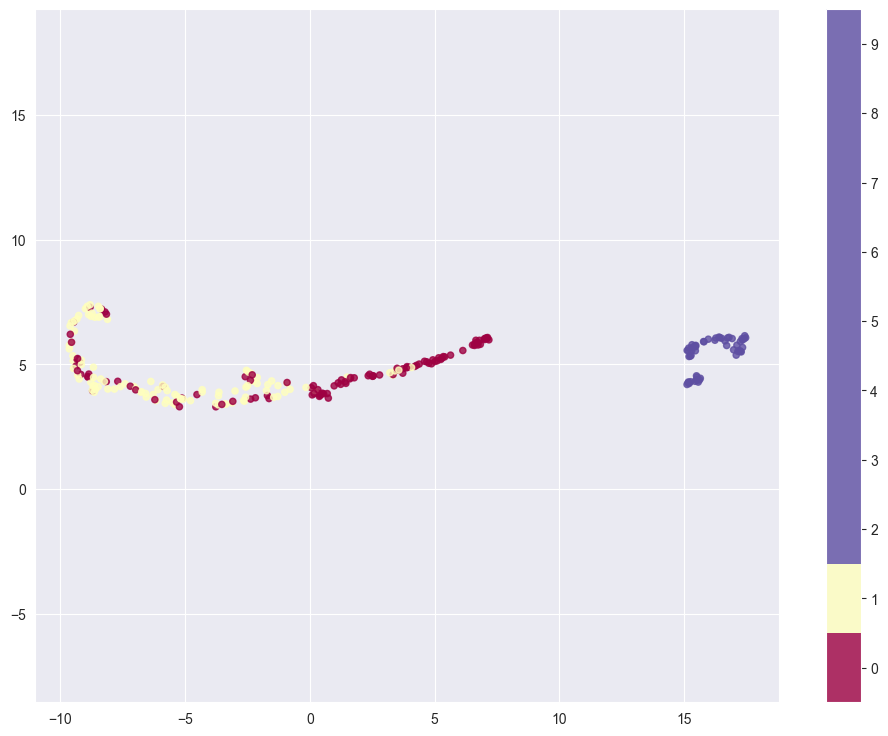

In [26]:
fig, ax = plt.subplots(figsize=(12, 9))
reducer = umap.UMAP(random_state=226313, n_jobs=1)
reducer.fit(sequence_embeddings)
embedding = reducer.transform(sequence_embeddings)
sct = plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap='Spectral', s=20, alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
cbar = fig.colorbar(sct, ticks=np.arange(10), boundaries=np.arange(11)-0.5)
cbar.ax.set_yticklabels(classes)
plt.title('UMAP projection of the surface embeddings', fontsize=12);

### One-hot labels encoding

In [21]:
lb = LabelBinarizer()
lb.fit(y)
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

### Classification layer

In [43]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.encoder = cnn_model
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

model = LinearClassifier(input_size=EMBEDDING_SIZE, output_size=num_classes).to(device)

### Loss function

In [33]:
criterion = nn.CrossEntropyLoss()

### Optimizer

In [46]:
optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=1e-3,
    )
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Training loop

In [47]:
train_batches = len(train_dataloader)
val_batches = len(val_dataloader)

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    pbar = tqdm(train_dataloader, total=train_batches)
    model.train()
    for idx, (batch_x, batch_y) in enumerate(pbar):
        optimizer.zero_grad()
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        train_outputs = model(batch_x)
        train_loss = criterion(train_outputs, batch_y)
        running_train_loss += train_loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
    scheduler.step()

    pbar_val = tqdm(val_dataloader, total=val_batches)
    model.eval()
    with torch.no_grad():
        for idx, (batch_x_val, batch_y_val) in enumerate(pbar_val):
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            batch_x_val = batch_x_val.permute(0, 2, 1)
            val_outputs = model(batch_x_val)
            val_loss = criterion(val_outputs, batch_y_val)
            running_val_loss += val_loss
            
            pbar_val.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
            
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_train_loss,
        'val_loss': running_val_loss,
    }, f"../data/checkpoints/cnn_classifier_{epoch + 1}.pt")

Epoch 10/10, Validation loss: 2.30E+00: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


### Test

In [48]:
test_batches = len(test_dataloader)
y_pred = []
running_test_loss = 0.0

pbar_test = tqdm(test_dataloader, total=test_batches)
model.eval()
with torch.no_grad():
    for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
        batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
        batch_x_test = batch_x_test.permute(0, 2, 1)
        test_outputs = model(batch_x_test)
        test_loss = criterion(test_outputs, batch_y_test)
        y_pred.append(torch.argmax(test_outputs).cpu().numpy())
        running_test_loss += test_loss
        
        pbar_test.set_description(f"Test loss: {running_test_loss / (idx + 1):.2E}")

Test loss: 2.30E+00: 100%|██████████| 268/268 [00:07<00:00, 35.03it/s]


### Confusion matrix

D:\GitHub Projects\Surface classification\surface-classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\GitHub Projects\Surface classification\surface-classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\GitHub Projects\Surface classification\surface-classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

                     precision    recall  f1-score   support

   10_Mata_ukladana       0.00      0.00      0.00        27
           1_Panele       0.00      0.00      0.00        28
2_Wykladzina_czarna       0.40      0.07      0.12        27
 3_Wykladzina_jasna       0.00      0.00      0.00        26
            4_Trawa       0.00      0.00      0.00        27
    5_Spienione_PCV       0.07      0.50      0.12        26
         6_Linoleum       0.00      0.00      0.00        26
    7_Plytki_w_sali       0.00      0.00      0.00        27
      8_Pusta_plyta       0.00      0.00      0.00        26
         9_podklady       0.00      0.00      0.00        28

           accuracy                           0.06       268
          macro avg       0.05      0.06      0.02       268
       weighted avg       0.05      0.06      0.02       268


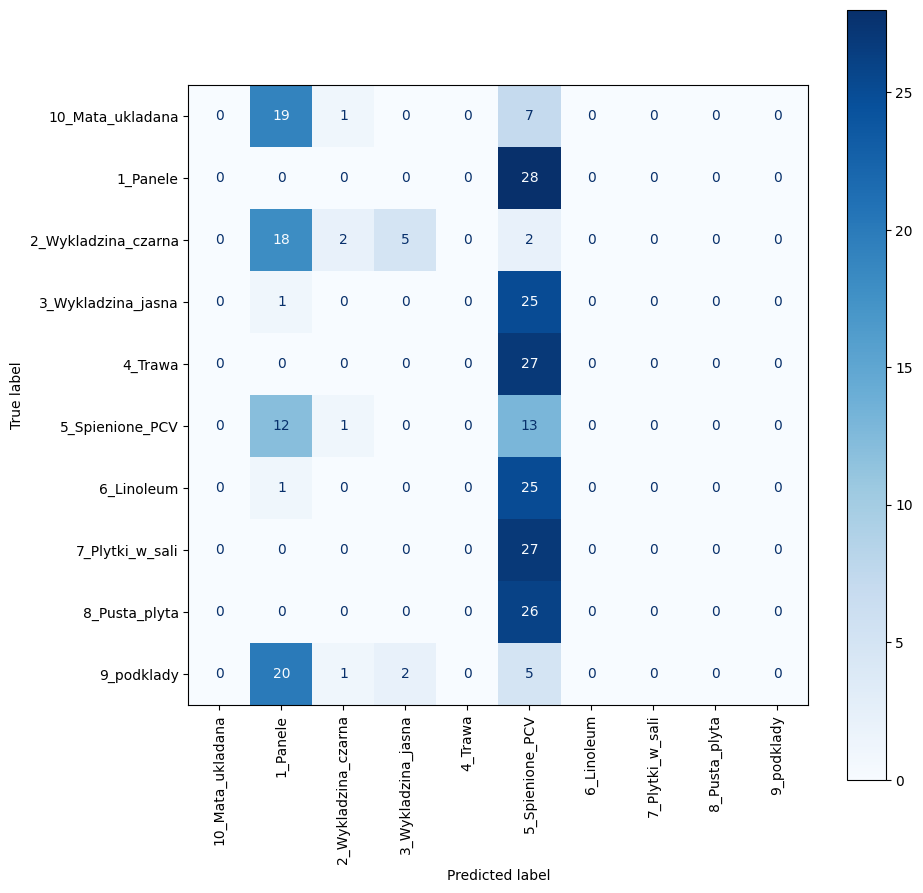

In [50]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

# y_test = lb.inverse_transform(y_test)
print(classification_report(y_test, y_pred, target_names=classes))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, xticks_rotation='vertical', cmap='Blues', ax=ax)